# Data Science and Big Data Project1
## Intermediate Progress
Group 14: Honda Zhang, Jessica Zhu

**Summary:** By now, we basically finished two parts: *data collection and cleaning, finding countries sharing similar music tastes.*

**1. Data collection and cleaning**
Our current dataset has three components:
- Weekly top 200 songs from 59 countries (2017-2019): `top_songs_country.csv`
- Audio features for each song: `audio_features.csv`
- Lyrics for each song (only English songs): `lyrics.csv`

To get these datasets, we created several python files and jupyter notebooks to scrap data from Spotify API and Genius API and clean the data. We included all these files in the zip file. Below is the brief instruction of all those files:

- `top_200_songs_scrapper.py`: scraping weekly top 200 songs from 59 countries and store data from each country as a csv file separately.
- `total_rank_df.py`: read weekly top 200 songs from each country and use the total counts of each songs to re-rank songs and store the result as a csv file separtely.
- `get_track_features.py`: scraping audio features for all the songs in our dataset from Spotify API.
- `scrap_lyrics.ipynb`: scraping lyrics from Genius API.

**2. Finding countries sharing similar music tastes**
To define similarity for music taste, we tried two methods: 
- couting number of same songs in top 100 songs
- create one-hot-encoding features and clustering

To see the details of this part, please see the below cells in this notebook.

**Next Steps**:
1. Improving current methods of finding similar countries: currently we used one-hot-encoding, we might find a creative way to incorporate ranking information in the encoding part and then clustering.
2. Analysing audio features and lyrics for each group of countries: need to figure out a better way to presenting findings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
mapping_df = pd.read_csv('region_mapping.csv', header=None)
list_of_ac = mapping_df[0].tolist()
list_of_full = mapping_df[1].tolist()
countries = list(zip(list_of_ac, list_of_full))

In [3]:
df_rank = pd.DataFrame()
for country in countries:
    file_name = 'total_rank_data/' + country[0] + '.csv'
    temp = pd.read_csv(file_name)
    famous_song_series = temp[['Track Name', 'spotify_id']][:100]
    famous_song_df = pd.DataFrame({'Name': famous_song_series['Track Name'],\
                                   'spotify_id': famous_song_series['spotify_id'],
                                   'Country': country[1]})
    df_rank = df_rank.append(famous_song_df)
df_rank.head()

Name              spotify_id    Country
0              Crimen  3oqWr0jDWNXxWufNogGREp  Argentina
1                Creo  5Bi9Cq5oVFy1OtUgecbegZ  Argentina
2  Spaghetti del Rock  6rg1MBZqggsQ5olFGTw0rr  Argentina
3         Nunca quise  0ZAJ660VP57lLK4U7NlGOy  Argentina
4            Me Gusta  3pMo77B4r1NwwIK78lO4xf  Argentina

In [4]:
df_rank = df_rank.reset_index()
df_rank = df_rank.rename(columns = {'index':'rank'})
df_rank.head()

rank                Name              spotify_id    Country
0     0              Crimen  3oqWr0jDWNXxWufNogGREp  Argentina
1     1                Creo  5Bi9Cq5oVFy1OtUgecbegZ  Argentina
2     2  Spaghetti del Rock  6rg1MBZqggsQ5olFGTw0rr  Argentina
3     3         Nunca quise  0ZAJ660VP57lLK4U7NlGOy  Argentina
4     4            Me Gusta  3pMo77B4r1NwwIK78lO4xf  Argentina

In [5]:
df_rank.to_csv('top_songs_country.csv')

In [6]:
country_matrix_rank = pd.DataFrame(columns=[country[1] for country in countries])

In [7]:
for country in countries:
    score_list = []
    current_temp = df_rank[df_rank['Country'] == country[1]]
    for counterparty in country_matrix_rank.iteritems():
        counterparty_temp = df_rank[df_rank['Country'] == counterparty[0]]
        temp = counterparty_temp.merge(current_temp, left_on='Name', right_on='Name')
        score_list.append(len(temp)/len(current_temp))
    country_matrix_rank.loc[country[1]] = score_list

In [9]:
# filter country that not similar with other
unique_country = list(country_matrix_rank[country_matrix_rank.sum(axis = 1) < 7].index)

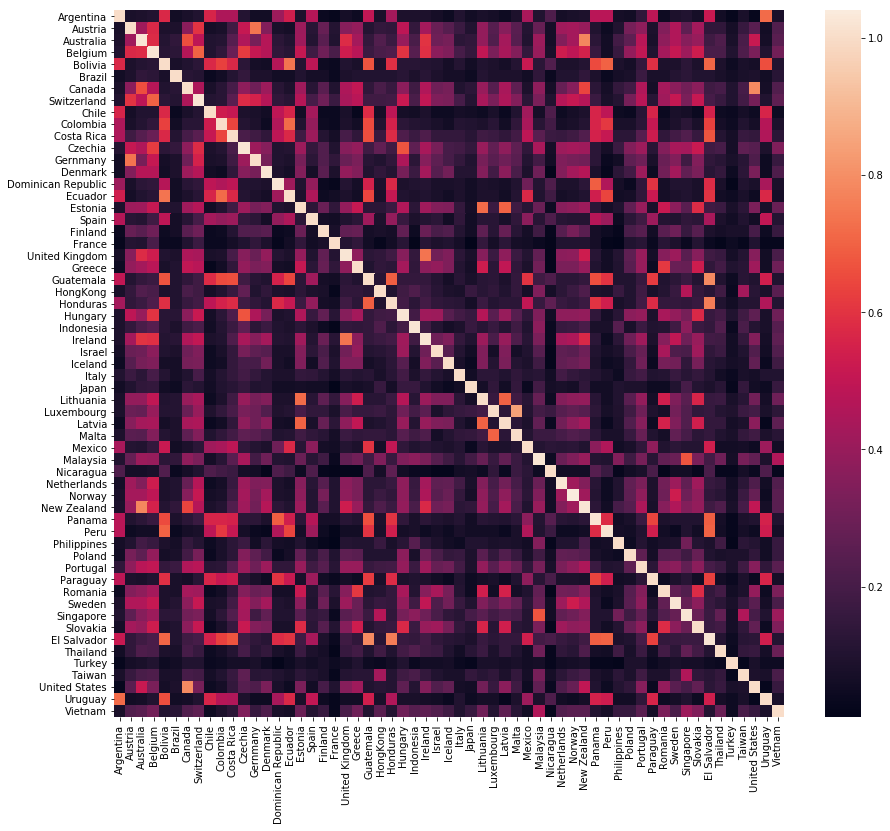

In [23]:
plt.figure(figsize = (15,13))
sns.heatmap(country_matrix_rank)

From this plot, we can see that some of the countries share similar music tastes. However, it's hard to use the result to group similar countries. Therefore, we tried to use clustering method the find the similar countries.

df_rank.head(10)

# Clustering

In [10]:
# first use one-hot-encoding to create features
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [11]:
ohe_features = enc.fit_transform(np.array(df_rank['Name']).reshape(-1,1)).toarray()

In [12]:
enc.categories_

[array(['#ihanaa', "'Di Na Muli", "'Till I Collapse", ..., '鱗(うろこ)',
        '빨간 맛 Red Flavor', '피카부 Peek-A-Boo'], dtype=object)]

In [13]:
df_ohe = pd.DataFrame(ohe_features)

In [14]:
df_ohe['Country'] = df_rank.reset_index()['Country']

In [15]:
# sum ohe features by country
df_ohe = df_ohe.groupby('Country').sum()

In [16]:
df_ohe.head()

0     1     2     3     4     5     6     7     8     9     ...  \
Country                                                                ...   
Argentina   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...   
Australia   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...   
Austria     0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
Belgium     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
Bolivia     0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...   

           2121  2122  2123  2124  2125  2126  2127  2128  2129  2130  
Country                                                                
Argentina   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Australia   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Austria     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Belgium     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Bolivia     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 2131 columns]

In [17]:
# incorporate ranking information into the one hot encoder
def ohe_rank(df_ohe, df_rank, enc):
    df_ohe_rank = df_ohe.copy()
    ohe_dict = {i:enc.categories_[0][i] for i in df_ohe.columns}
    for country in df_ohe.index:
        for song in df_ohe.columns:
            if df_ohe_rank.loc[country][song] == 1:
                df_ohe_rank.loc[country][song] = 100-df_rank[(df_rank['Country'] == country)&
                                                    (df_rank['Name'] == ohe_dict[song])]['rank'] 
                # use 200-rank becuase we want to give higher rank more importance
    return df_ohe_rank

In [18]:
df_ohe_rank = ohe_rank(df_ohe, df_rank, enc)

In [19]:
df_ohe_rank.head()

0     1     2     3     4     5     6     7     8     9     ...  \
Country                                                                ...   
Argentina   0.0   0.0   0.0   0.0   0.0   0.0   0.0  33.0   0.0   0.0  ...   
Australia   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  78.0   0.0  ...   
Austria     0.0   0.0  80.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
Belgium     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
Bolivia     0.0   0.0   0.0   0.0   0.0   0.0   0.0  46.0   0.0   0.0  ...   

           2121  2122  2123  2124  2125  2126  2127  2128  2129  2130  
Country                                                                
Argentina   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Australia   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Austria     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Belgium     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Bolivia     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 2131 columns]

In [20]:
df_ohe_cluster = df_ohe_rank.copy()
df_ohe_cluster.drop(index = unique_country, inplace = True)

In [101]:
df_rank

rank                Name              spotify_id    Country
0        0              Crimen  3oqWr0jDWNXxWufNogGREp  Argentina
1        1                Creo  5Bi9Cq5oVFy1OtUgecbegZ  Argentina
2        2  Spaghetti del Rock  6rg1MBZqggsQ5olFGTw0rr  Argentina
3        3         Nunca quise  0ZAJ660VP57lLK4U7NlGOy  Argentina
4        4            Me Gusta  3pMo77B4r1NwwIK78lO4xf  Argentina
...    ...                 ...                     ...        ...
5795    95       DDU-DU DDU-DU  2aI2k39nfa3KFsa4JclQzw    Vietnam
5796    96   Someone You Loved  2TIlqbIneP0ZY1O0EzYLlc    Vietnam
5797    97            Believer  0pqnGHJpmpxLKifKRmU6WP    Vietnam
5798    98   Mượn Rượu Tỏ Tình  3TXSdTpaqKBpWyUG3aJ3LK    Vietnam
5799    99              Sucker  22vgEDb5hykfaTwLuskFGD    Vietnam

[5800 rows x 4 columns]

In [102]:
df_ohe_unique_country = df_rank[df_rank['Country'].isin(unique_country)]

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_k = None
best_labels = None
best_score = -1
best_model = None

scores_kmeans = {}

for k in range(2, 21):
    
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(df_ohe_cluster)
    
    labels = kmeans.labels_
    score = silhouette_score(df_ohe_cluster, labels)
    scores_kmeans[k] = score
    print('k =', k, 'has silhouette score', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = kmeans
        best_labels = labels

print()
print("Best k = " + str(best_k), 'according to silhouette score')
print()


k = 2 has silhouette score 0.16207400835225955
k = 3 has silhouette score 0.1740694057962407
k = 4 has silhouette score 0.14282014940268797
k = 5 has silhouette score 0.13021231496988062
k = 6 has silhouette score 0.1316554524975035
k = 7 has silhouette score 0.14389069123909745
k = 8 has silhouette score 0.13782269511944467
k = 9 has silhouette score 0.13490663306681597
k = 10 has silhouette score 0.07056829166083886
k = 11 has silhouette score 0.08137760594140614
k = 12 has silhouette score 0.08051802010207512
k = 13 has silhouette score 0.08028491961231327
k = 14 has silhouette score 0.07631151188849945
k = 15 has silhouette score 0.08460402199459437
k = 16 has silhouette score 0.08764684288615278
k = 17 has silhouette score 0.08478498314385624
k = 18 has silhouette score 0.1013682662303677
k = 19 has silhouette score 0.11011744748003013
k = 20 has silhouette score 0.10997419003059183

Best k = 3 according to silhouette score



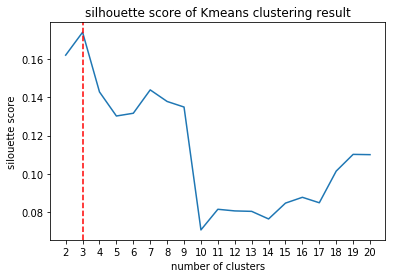

In [23]:
plt.plot(list(scores_kmeans.keys()), list(scores_kmeans.values()))
plt.axvline(x = best_k, color = 'r', linestyle = '--')
plt.xticks(list(scores_kmeans.keys()))
plt.ylabel('silouette score')
plt.xlabel('number of clusters')
plt.title('silhouette score of Kmeans clustering result')
plt.show()

In [24]:
kmeans = KMeans(n_clusters = best_k, random_state = 0)
kmeans.fit(df_ohe_cluster)
df_ohe_cluster['Cluster'] = kmeans.labels_

In [25]:
df_ohe_cluster['Cluster'].value_counts()

1    29
0    16
2     8
Name: Cluster, dtype: int64

In [26]:
df_ohe_cluster.groupby('Cluster').get_group(0).index

Index(['Argentina', 'Bolivia', 'Chile', 'Colombia', 'Costa Rica',
       'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras',
       'Mexico', 'Panama', 'Paraguay', 'Peru', 'Spain', 'Uruguay'],
      dtype='object', name='Country')

In [27]:
df_ohe_cluster.groupby('Cluster').get_group(1).index

Index(['Australia', 'Austria', 'Belgium', 'Canada', 'Czechia', 'Denmark',
       'Estonia', 'Finland', 'Gernmany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Israel', 'Italy', 'Latvia', 'Lithuania', 'Malta',
       'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Sweden', 'Switzerland', 'United Kingdom', 'United States'],
      dtype='object', name='Country')

In [28]:
df_ohe_cluster.groupby('Cluster').get_group(2).index

Index(['HongKong', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore',
       'Taiwan', 'Thailand', 'Vietnam'],
      dtype='object', name='Country')

In [29]:
cluster_regions = ['South America', 'European & North America','Southeast Asia']

In [33]:
group_0 = df_rank.loc[df_rank['Country'].isin(list(df_ohe_cluster.groupby('Cluster').get_group(0).index))]
group_1 = df_rank.loc[df_rank['Country'].isin(list(df_ohe_cluster.groupby('Cluster').get_group(1).index))]
group_2 = df_rank.loc[df_rank['Country'].isin(list(df_ohe_cluster.groupby('Cluster').get_group(2).index))]

In [34]:
group_0.head()

rank                Name              spotify_id    Country
0     0              Crimen  3oqWr0jDWNXxWufNogGREp  Argentina
1     1                Creo  5Bi9Cq5oVFy1OtUgecbegZ  Argentina
2     2  Spaghetti del Rock  6rg1MBZqggsQ5olFGTw0rr  Argentina
3     3         Nunca quise  0ZAJ660VP57lLK4U7NlGOy  Argentina
4     4            Me Gusta  3pMo77B4r1NwwIK78lO4xf  Argentina

# Analysis Track Features
https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/

In [35]:
track_features = pd.read_csv('audio_features.csv')

In [36]:
track_features.head()

Unnamed: 0  danceability  energy  key  loudness  mode  speechiness  \
0           0         0.799   0.722    7    -5.051     1       0.0387   
1           1         0.553   0.964    0    -6.710     1       0.0568   
2           2         0.668   0.816    9    -3.708     0       0.0322   
3           3         0.547   0.881    4    -5.994     0       0.3100   
4           4         0.639   0.745    0    -3.631     1       0.0416   

   acousticness  instrumentalness  liveness  valence    tempo            type  \
0       0.35900          0.000000     0.178    0.880  128.012  audio_features   
1       0.00221          0.017600     0.060    0.530  133.935  audio_features   
2       0.03110          0.000025     0.195    0.550  129.975  audio_features   
3       0.11100          0.000000     0.386    0.440   86.628  audio_features   
4       0.11000          0.000000     0.131    0.356  139.993  audio_features   

                       id                                   uri  \
0  2EhvCzRw0C7anZHsj284oX  spotify:track:2EhvCzRw0C7anZHsj284oX   
1  6BI4NrjNsQfac2erXVjSVf  spotify:track:6BI4NrjNsQfac2erXVjSVf   
2  3CZoTwEuhvrokhej4VAo0Q  spotify:track:3CZoTwEuhvrokhej4VAo0Q   
3  7CbkW1lLxOM5D6YWTnzknv  spotify:track:7CbkW1lLxOM5D6YWTnzknv   
4  4ffYbqNOSn01NHOmQGJEKT  spotify:track:4ffYbqNOSn01NHOmQGJEKT   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2EhvCzRw0C7a...   
1  https://api.spotify.com/v1/tracks/6BI4NrjNsQfa...   
2  https://api.spotify.com/v1/tracks/3CZoTwEuhvro...   
3  https://api.spotify.com/v1/tracks/7CbkW1lLxOM5...   
4  https://api.spotify.com/v1/tracks/4ffYbqNOSn01...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/2Ehv...       176906   
1  https://api.spotify.com/v1/audio-analysis/6BI4...       220177   
2  https://api.spotify.com/v1/audio-analysis/3CZo...       253027   
3  https://api.spotify.com/v1/audio-analysis/7Cbk...       166486   
4  https://api.spotify.com/v1/audio-analysis/4ffY...       193948   

   time_signature  
0               4  
1               4  
2               4  
3               4  
4               4

In [103]:
group_0_audio = pd.merge(group_0, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')
group_1_audio = pd.merge(group_1, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')
group_2_audio = pd.merge(group_2, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')
unique_country_audio = pd.merge(df_ohe_unique_country, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')

In [38]:
hist_columns = list(track_features.columns[:12]) + list(track_features.columns[-2:-1])
hist_columns.remove('mode')
hist_columns.remove('Unnamed: 0')

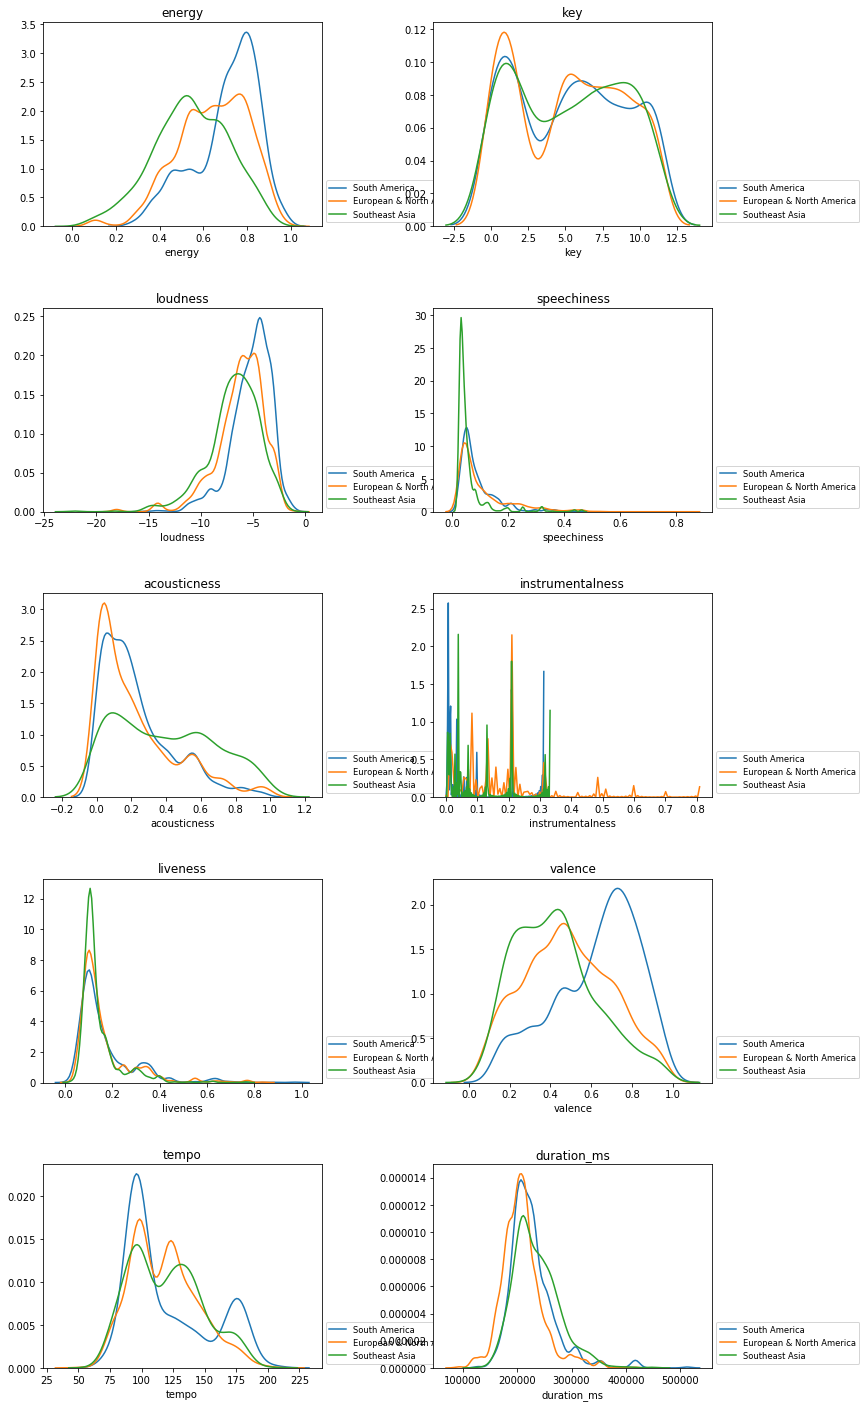

In [40]:
fig = plt.figure(figsize = (12,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(6, 2, i)
    l1=sns.distplot(group_0_audio[hist_columns[i]], hist = False, label = cluster_regions[0])
    l2=sns.distplot(group_1_audio[hist_columns[i]], hist = False, label = cluster_regions[1])
    l3=sns.distplot(group_2_audio[hist_columns[i]], hist = False, label = cluster_regions[2])
    ax.set_title(hist_columns[i])
    ax.legend(fontsize = 'small', loc = 'lower left', bbox_to_anchor=(1, 0))

plt.show()

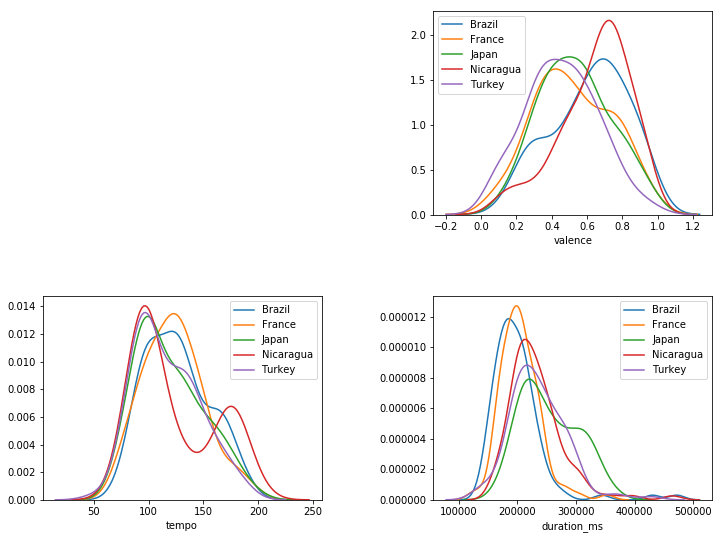

In [121]:
fig = plt.figure(figsize = (12,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(8, 11):
    ax = fig.add_subplot(6, 2, i)   
    for country in unique_country:
        data = unique_country_audio[unique_country_audio['Country'] == country]
        sns.distplot(data[hist_columns[i]], hist = False, label = country)
plt.legend()
plt.show()

In [41]:
group_0_audio['key'].value_counts()

11    199
1     189
0     181
2     155
5     148
6     145
7     144
9     133
8     103
4      94
10     78
3      31
Name: key, dtype: int64

In [42]:
group_1_audio['key'].value_counts()

1     435
5     330
0     303
11    251
9     250
7     250
8     242
6     234
2     220
10    189
4     151
3      45
Name: key, dtype: int64

In [43]:
group_2_audio['key'].value_counts()

1     95
0     90
9     77
7     76
2     75
10    71
8     61
5     57
4     57
11    56
6     54
3     31
Name: key, dtype: int64

## Lyrics Analysis

In [44]:
lyrics = pd.read_csv('lyrics.csv')

In [45]:
lyrics.head()

Unnamed: 0             Track Name            Artist  \
0           0  Closer (feat. Halsey)  The Chainsmokers   
1           1   Say You Won't Let Go      James Arthur   
2           2             Photograph        Ed Sheeran   
3           3       A Thousand Years   Christina Perri   
4           4                  Faded       Alan Walker   

               spotify_id                                             lyrics  
0  7BKLCZ1jbUBVqRi2FVlTVw  \n\n2014\n"#SELFIE"\n\n2016\n"Roses" (feat. RO...  
1  5uCax9HTNlzGybIStD3vDh  \n\n[Verse 1]\nI remember when you were all mi...  
2  6fxVffaTuwjgEk5h9QyRjy  \n\n[Verse 1]\nLoving can hurt, loving can hur...  
3  6lanRgr6wXibZr8KgzXxBl                             \n\n[Instrumental]\n\n  
4  698ItKASDavgwZ3WjaWjtz  \n\n[Verse]\nYou were the shadow to my light\n...

In [46]:
len(lyrics)

45469

In [47]:
# preprocessing text
import spacy
nlp = spacy.load('en', disable=['ner'], max_length = 1000000000)

In [48]:
corpus = [nlp(text) for text in list(lyrics['lyrics'])]

In [49]:
# create tokenized text
corpus_tokens, verbs, nouns, adverbs = [],[],[],[]
 
for doc in corpus:
    tokens,verb, noun, adverb = [],[],[],[]
    for token in doc:
        if token.lemma_ == "-PRON-":
            lemma = token.text
        else:
            lemma = token.lemma_
        
        if token.pos_ == r'VERB':
            verb.append(lemma)
        elif token.pos_ == r'NOUN':
            noun.append(lemma)
        elif token.pos_ == 'ADV':
            adverb.append(lemma)
        
        tokens.append(lemma)
            
    verbs.append(verb)
    nouns.append(noun)
    adverbs.append(adverb)
    corpus_tokens.append(tokens)
            

In [51]:
lyrics['token'] = corpus_tokens
lyrics['nouns'] = nouns
lyrics['verbs'] = verbs
lyrics['adverbs'] = adverbs

In [53]:
lyrics.head(3)

Unnamed: 0             Track Name            Artist  \
0           0  Closer (feat. Halsey)  The Chainsmokers   
1           1   Say You Won't Let Go      James Arthur   
2           2             Photograph        Ed Sheeran   

               spotify_id                                             lyrics  \
0  7BKLCZ1jbUBVqRi2FVlTVw  \n\n2014\n"#SELFIE"\n\n2016\n"Roses" (feat. RO...   
1  5uCax9HTNlzGybIStD3vDh  \n\n[Verse 1]\nI remember when you were all mi...   
2  6fxVffaTuwjgEk5h9QyRjy  \n\n[Verse 1]\nLoving can hurt, loving can hur...   

                                               token  \
0  [\n\n, 2014, \n, ", #, selfie, ", \n\n, 2016, ...   
1  [\n\n, [, verse, 1, ], \n, I, remember, when, ...   
2  [\n\n, [, verse, 1, ], \n, loving, can, hurt, ...   

                                               nouns  \
0    [feat, feat, feat, feat, fire, feat, something]   
1  [verse, mine, front, eye, what, fire, hand, ni...   
2  [verse, thing, thing, love, photograph, memory...   

                                               verbs  \
0                               [do, let, know, set]   
1  [remember, be, watch, change, can, say, be, be...   
2  [can, hurt, love, can, hurt, be, know, get, kn...   

                                             adverbs  
0                                        [not, just]  
1  [when, now, not, now, not, away, not, not, til...  
2  [sometimes, when, hard, sometimes, where, neve...

In [54]:
group_0_lyrics = pd.merge(group_0, lyrics[['spotify_id','token','nouns','verbs','adverbs']], 
                          how = 'left', left_on = 'spotify_id', right_on = 'spotify_id')
group_1_lyrics = pd.merge(group_1, lyrics[['spotify_id','token','nouns','verbs','adverbs']], 
                          how = 'left', left_on = 'spotify_id', right_on = 'spotify_id')
group_2_lyrics = pd.merge(group_2, lyrics[['spotify_id','token','nouns','verbs','adverbs']], 
                          how = 'left', left_on = 'spotify_id', right_on = 'spotify_id')

In [55]:
group_0_lyrics.head()

rank                Name              spotify_id    Country  \
0     0              Crimen  3oqWr0jDWNXxWufNogGREp  Argentina   
1     1                Creo  5Bi9Cq5oVFy1OtUgecbegZ  Argentina   
2     2  Spaghetti del Rock  6rg1MBZqggsQ5olFGTw0rr  Argentina   
3     3         Nunca quise  0ZAJ660VP57lLK4U7NlGOy  Argentina   
4     4            Me Gusta  3pMo77B4r1NwwIK78lO4xf  Argentina   

                                               token  \
0  [\n\n, [, letra, de, ", crimen, ", ], \n\n, [,...   
1  [\n\n, el, fuego, ma, soberbio, que, la, vida,...   
2  [\n\n, [, letra, de, ", spaghetti, del, rock, ...   
3  [\n\n, [, letra, de, ", viviendo, con, él, ", ...   
4  [\n\n, en, la, noche, de, la, noche, \n, cuand...   

                                               nouns  \
0  [espera, no, degradé, que, perdí, cosa, puedo,...   
1  [fuego, ma, soberbio, vida, dar, razone, parar...   
2  [motor, viejo, este, amor, que, hostil, tiempo...   
3  [con, gana, verte, aquella, vez, confesaste, d...   
4  [noche, noche, dormía, era, mas, polenta, era,...   

                                               verbs  \
0                      [vos, llama, vez, sé, sé, sé]   
1  [call, encontraste, oyendo, sueño, tu, vez, ve...   
2                  [momia, ambición, ficción, momia]   
3  [desde, tortura, iba, escuchándote, iba, vez, ...   
4  [gallo, hizo, cuerpo, dejan, espié, lo, garpé,...   

                                             adverbs  
0  [agotó, nada, acosté, no, olvido, no, olvido, ...  
1                                                 []  
2                                              [paz]  
3                                           [siente]  
4                                               [no]

In [85]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add('PRON')
spacy_stopwords.add('oh')
spacy_stopwords.add('yeah')
spacy_stopwords.add('que')
spacy_stopwords.add('che')
spacy_stopwords.add('la')
spacy_stopwords.add('el')
spacy_stopwords.add('eh')
spacy_stopwords.add('ooh')
spacy_stopwords.add('doo')
spacy_stopwords.add('en')
spacy_stopwords.add('na')
spacy_stopwords.add('yo')
spacy_stopwords.add('chorus')
spacy_stopwords.add('pre')
spacy_stopwords.add('li')
spacy_stopwords.add('di')
spacy_stopwords.add('un')
spacy_stopwords.add('yeh')
spacy_stopwords.add('verse')
spacy_stopwords.add('il')
spacy_stopwords.add('non')
spacy_stopwords.add('mi')
spacy_stopwords.add('uh')
spacy_stopwords.add('ma')
spacy_stopwords.add('da')
spacy_stopwords.add('de')
spacy_stopwords.add('like')
spacy_stopwords.add('hol')
spacy_stopwords.add('doo')
spacy_stopwords.add('thunder')

In [80]:
def wordcloud(text, max_words):
    wordcloud = WordCloud(width = 4000,
                          height = 3000,
                          background_color="white",
                          stopwords = spacy_stopwords,
                          max_words = max_words).generate(text)
    plt.figure(figsize=(40,25))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    return

In [81]:
group_0_nouns = [word for sublist in list(group_0_lyrics['nouns']) for word in sublist]
group_0_nouns = ' '.join(group_0_nouns)

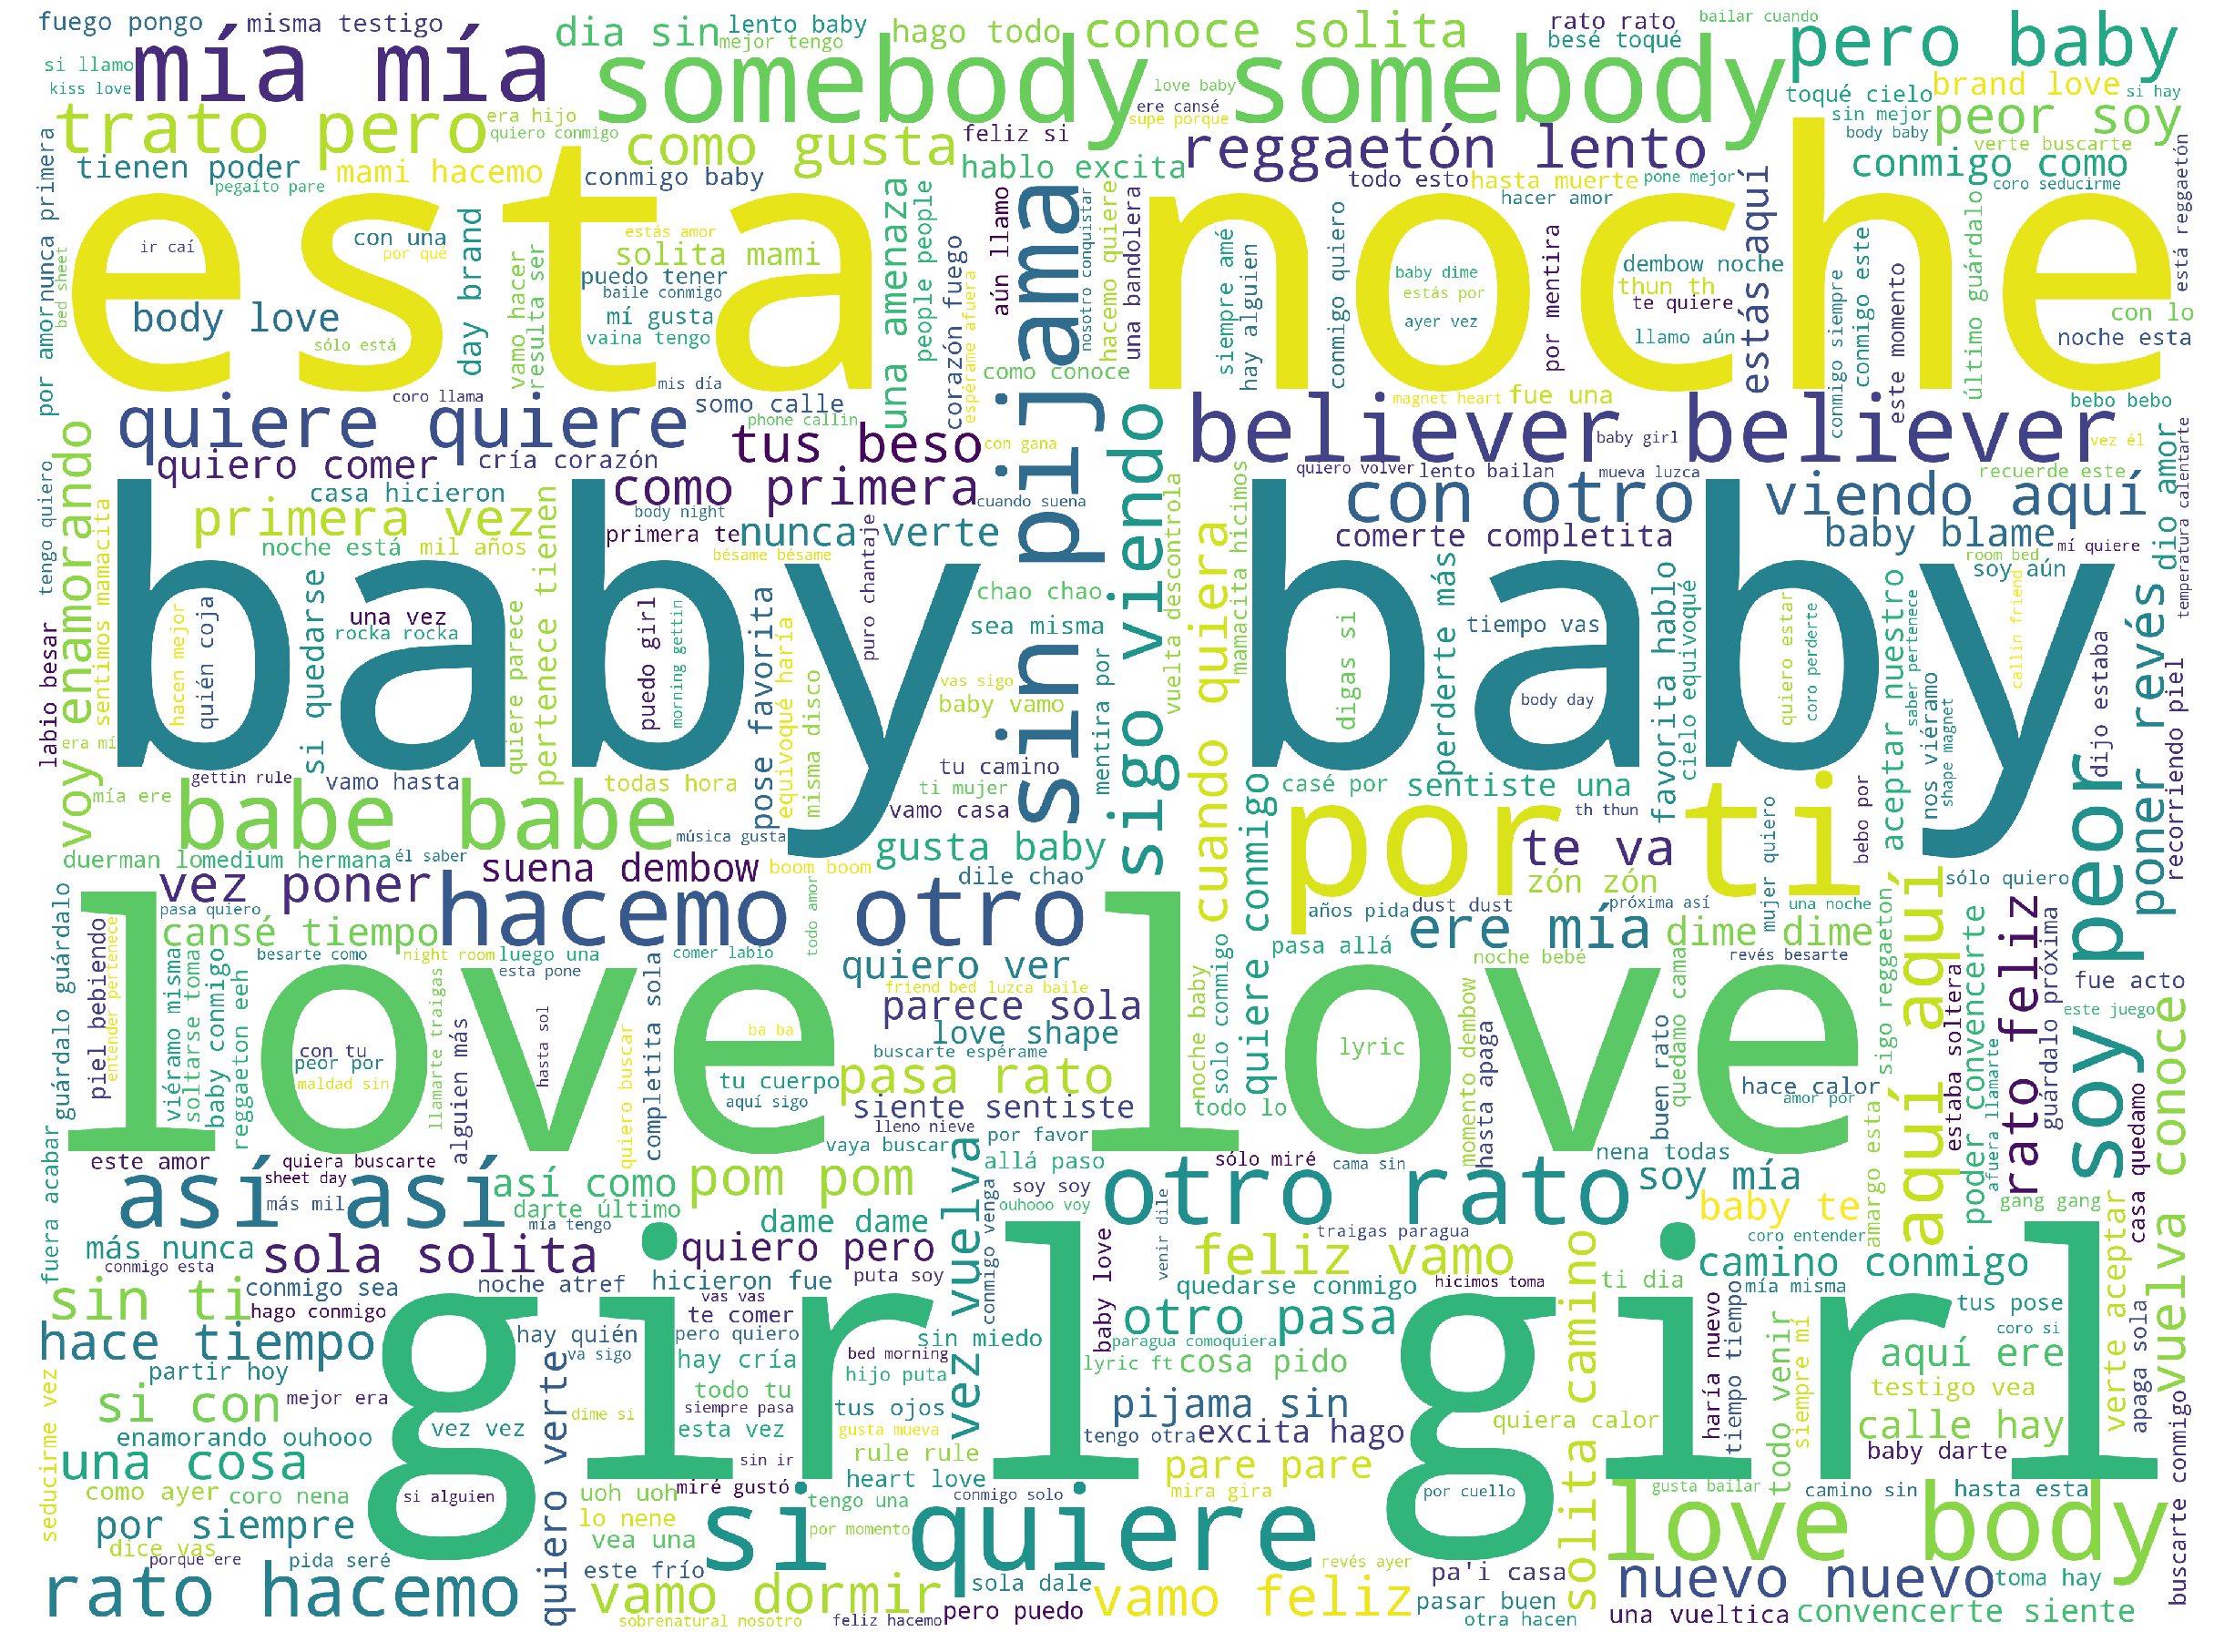

In [89]:
wordcloud(group_0_nouns, 400)

In [75]:
group_1_nouns = [word for sublist in list(group_1_lyrics['nouns']) for word in sublist]
group_1_nouns = ' '.join(group_1_nouns)

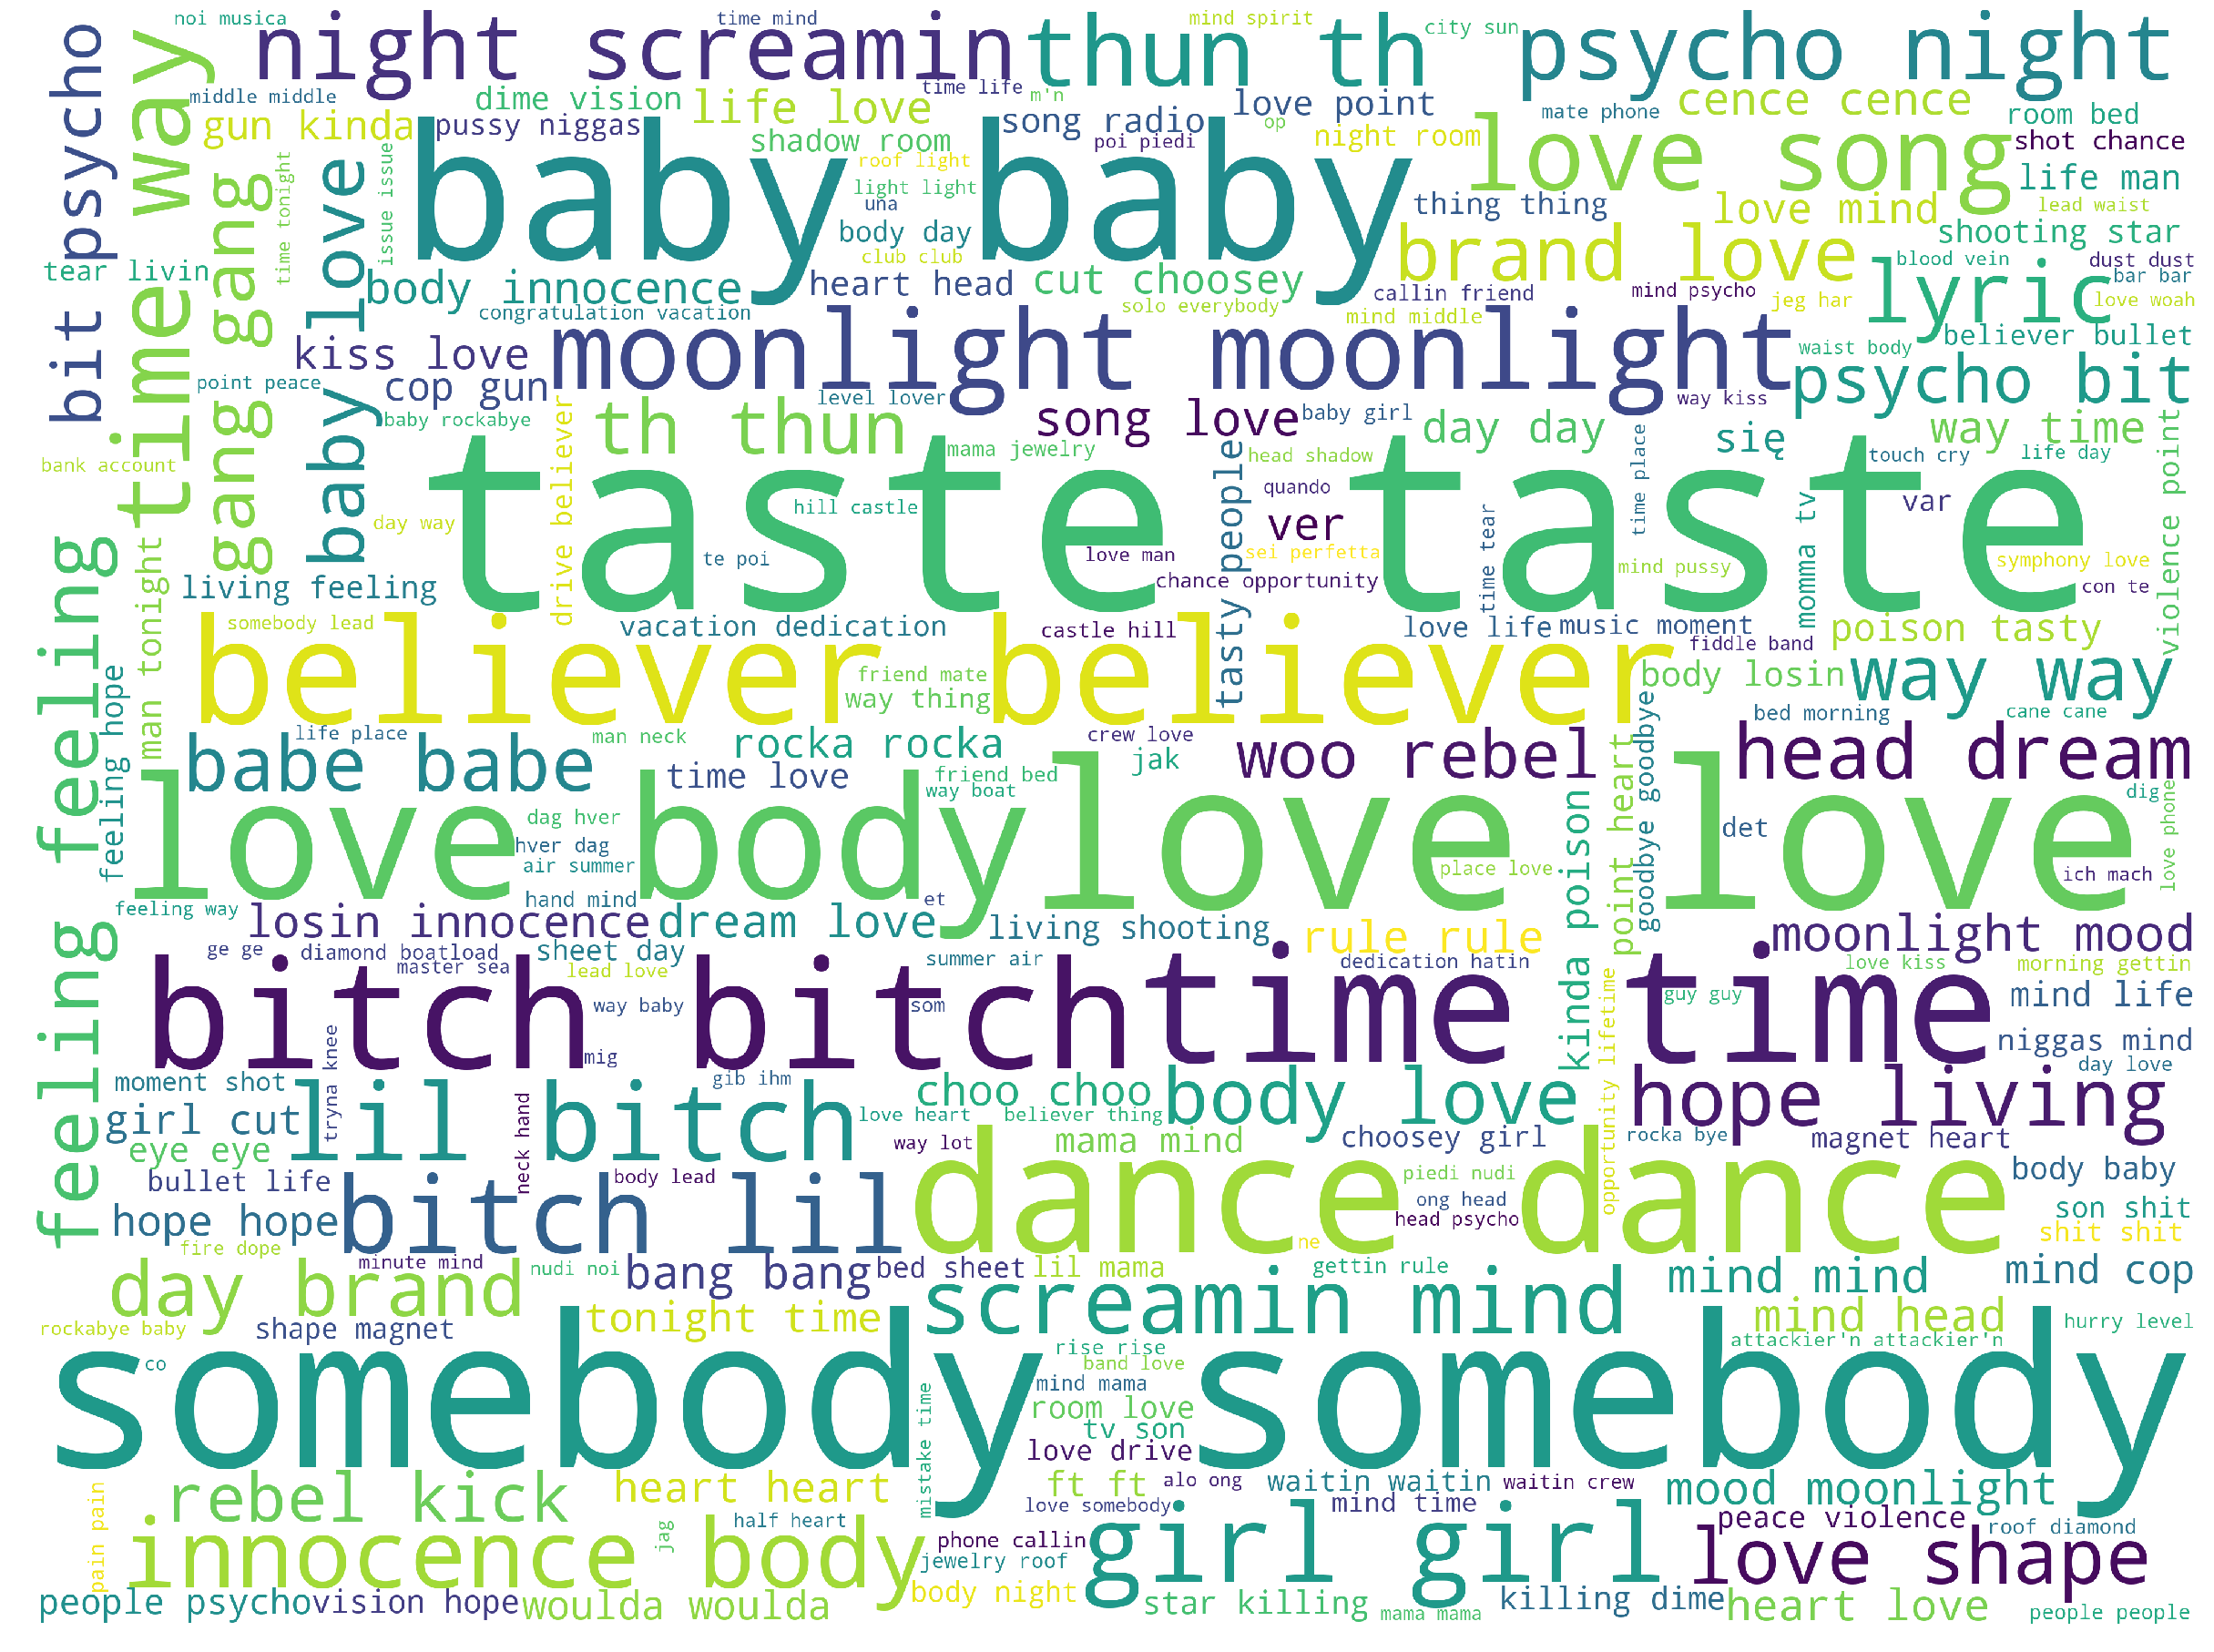

In [87]:
wordcloud(group_1_nouns,400)

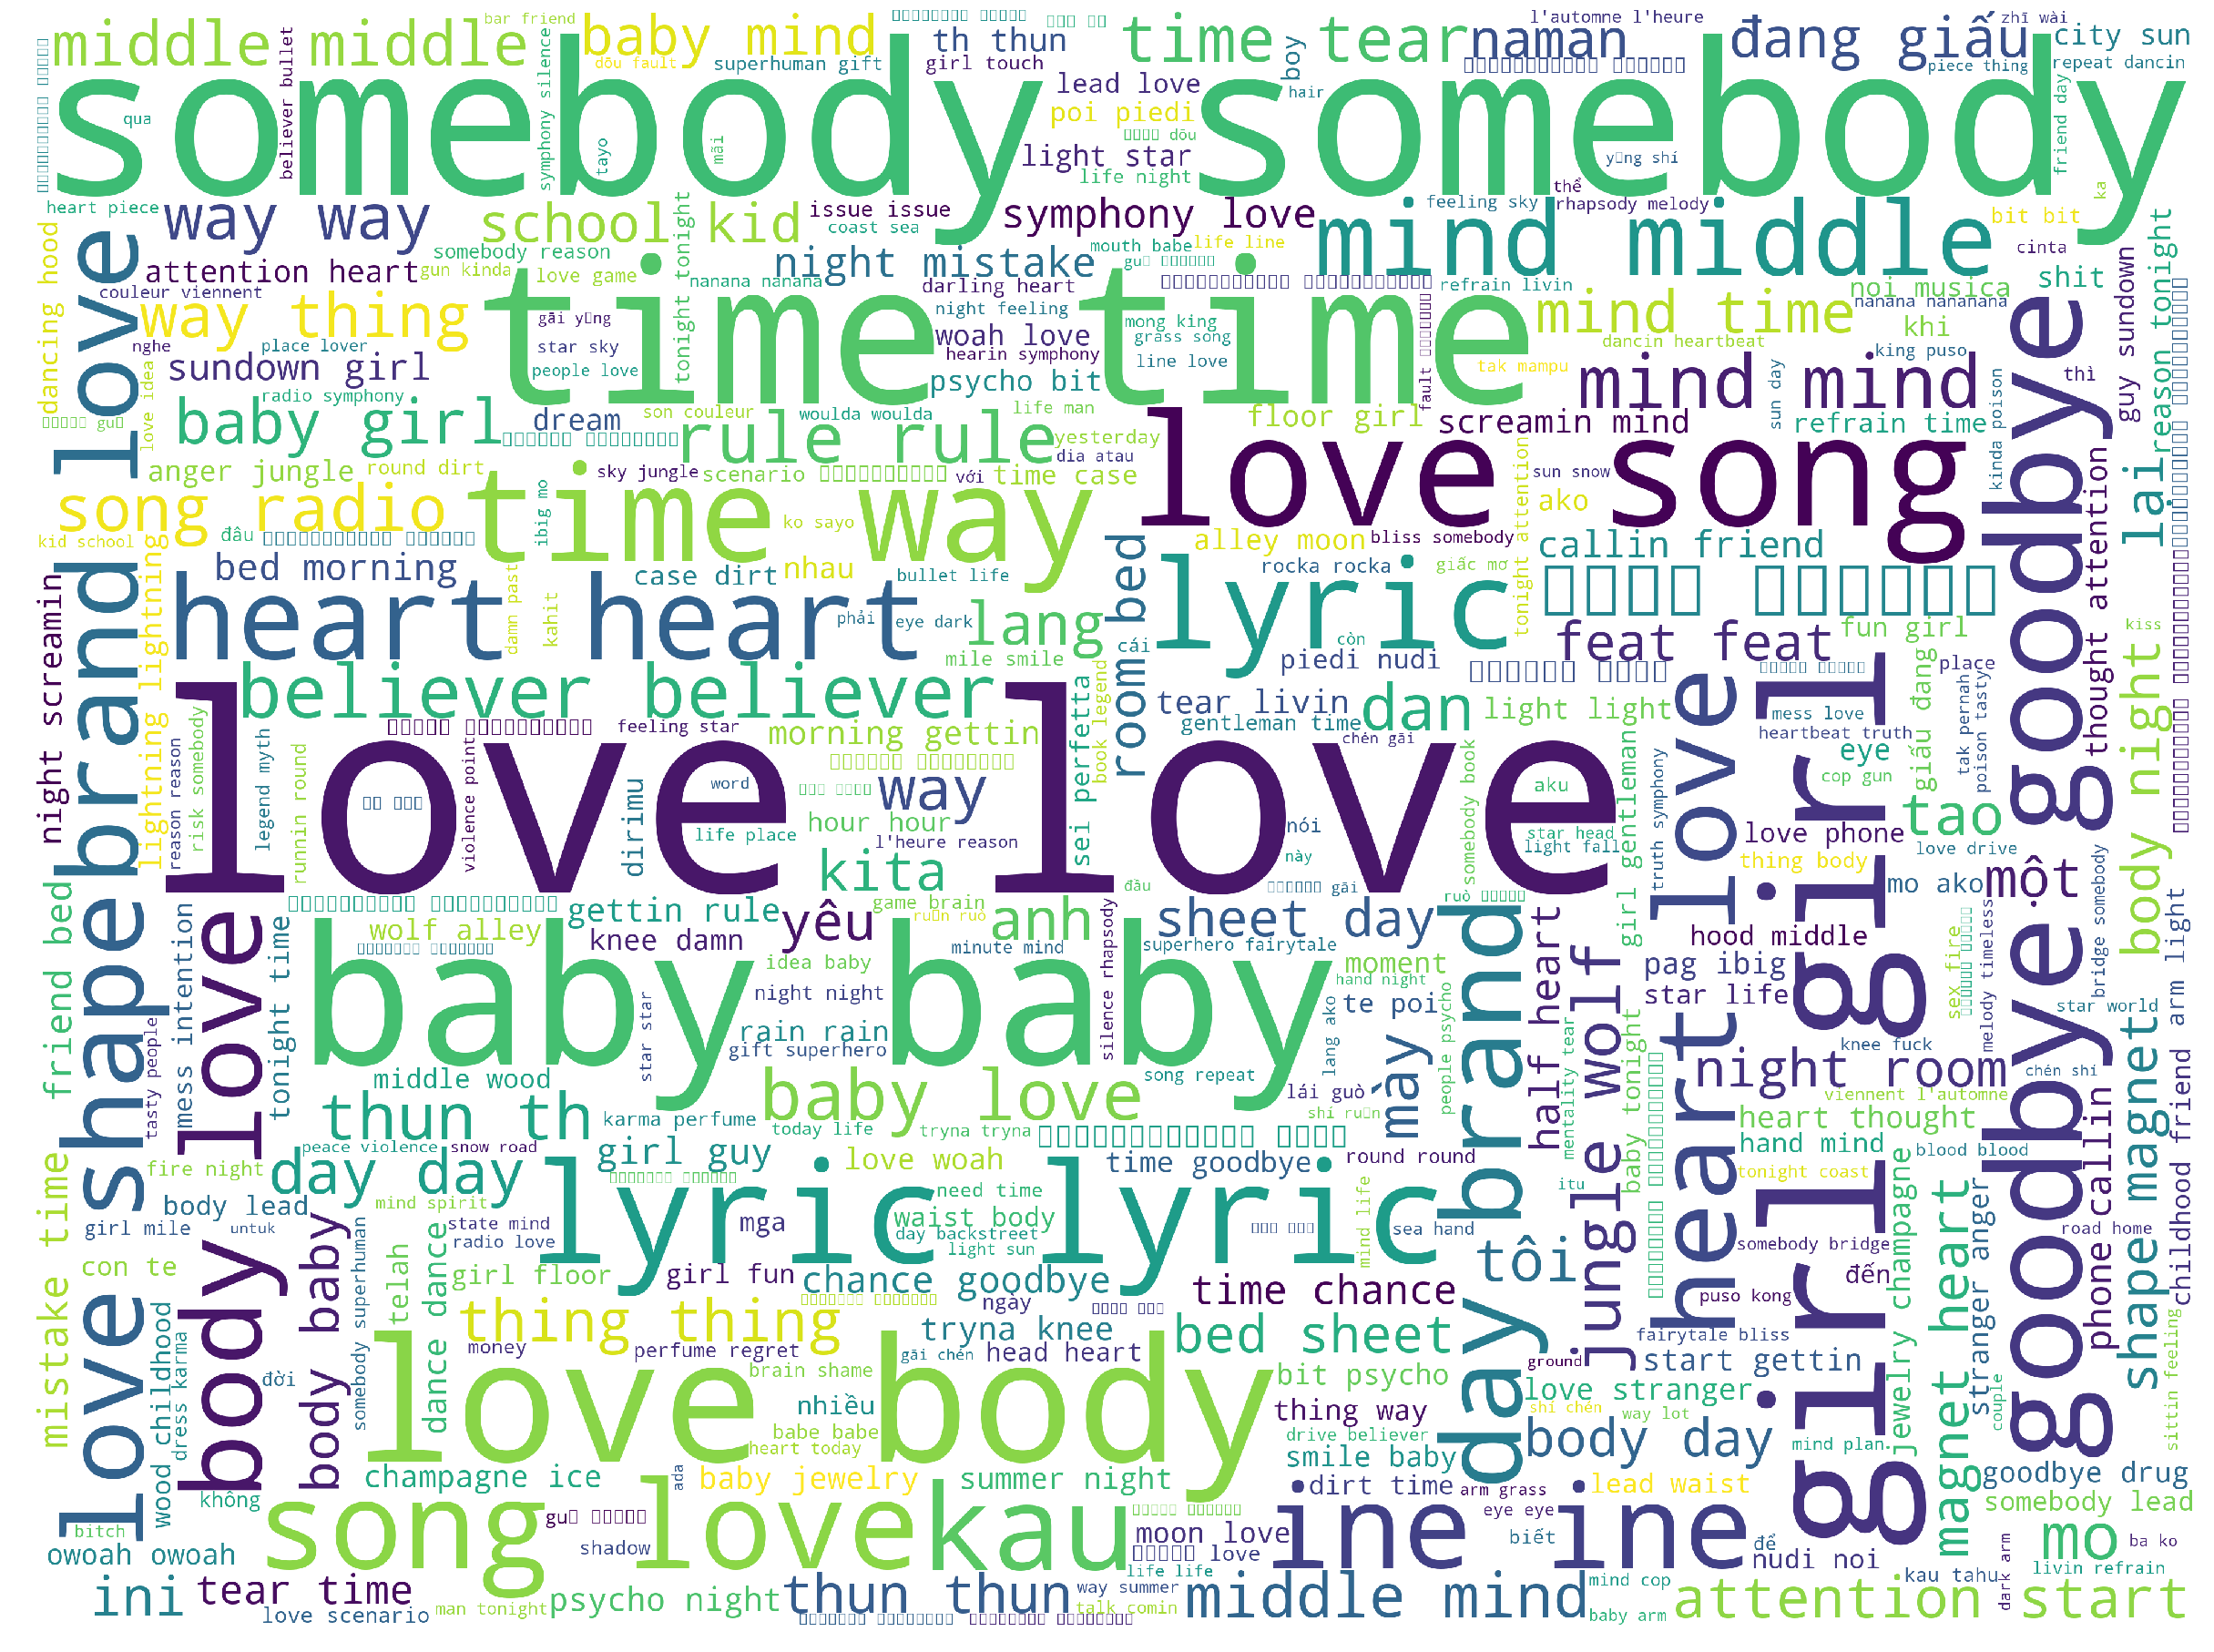

In [90]:
group_2_nouns = [word for sublist in list(group_2_lyrics['nouns']) for word in sublist]
group_2_nouns = ' '.join(group_2_nouns)
wordcloud(group_2_nouns, 400)

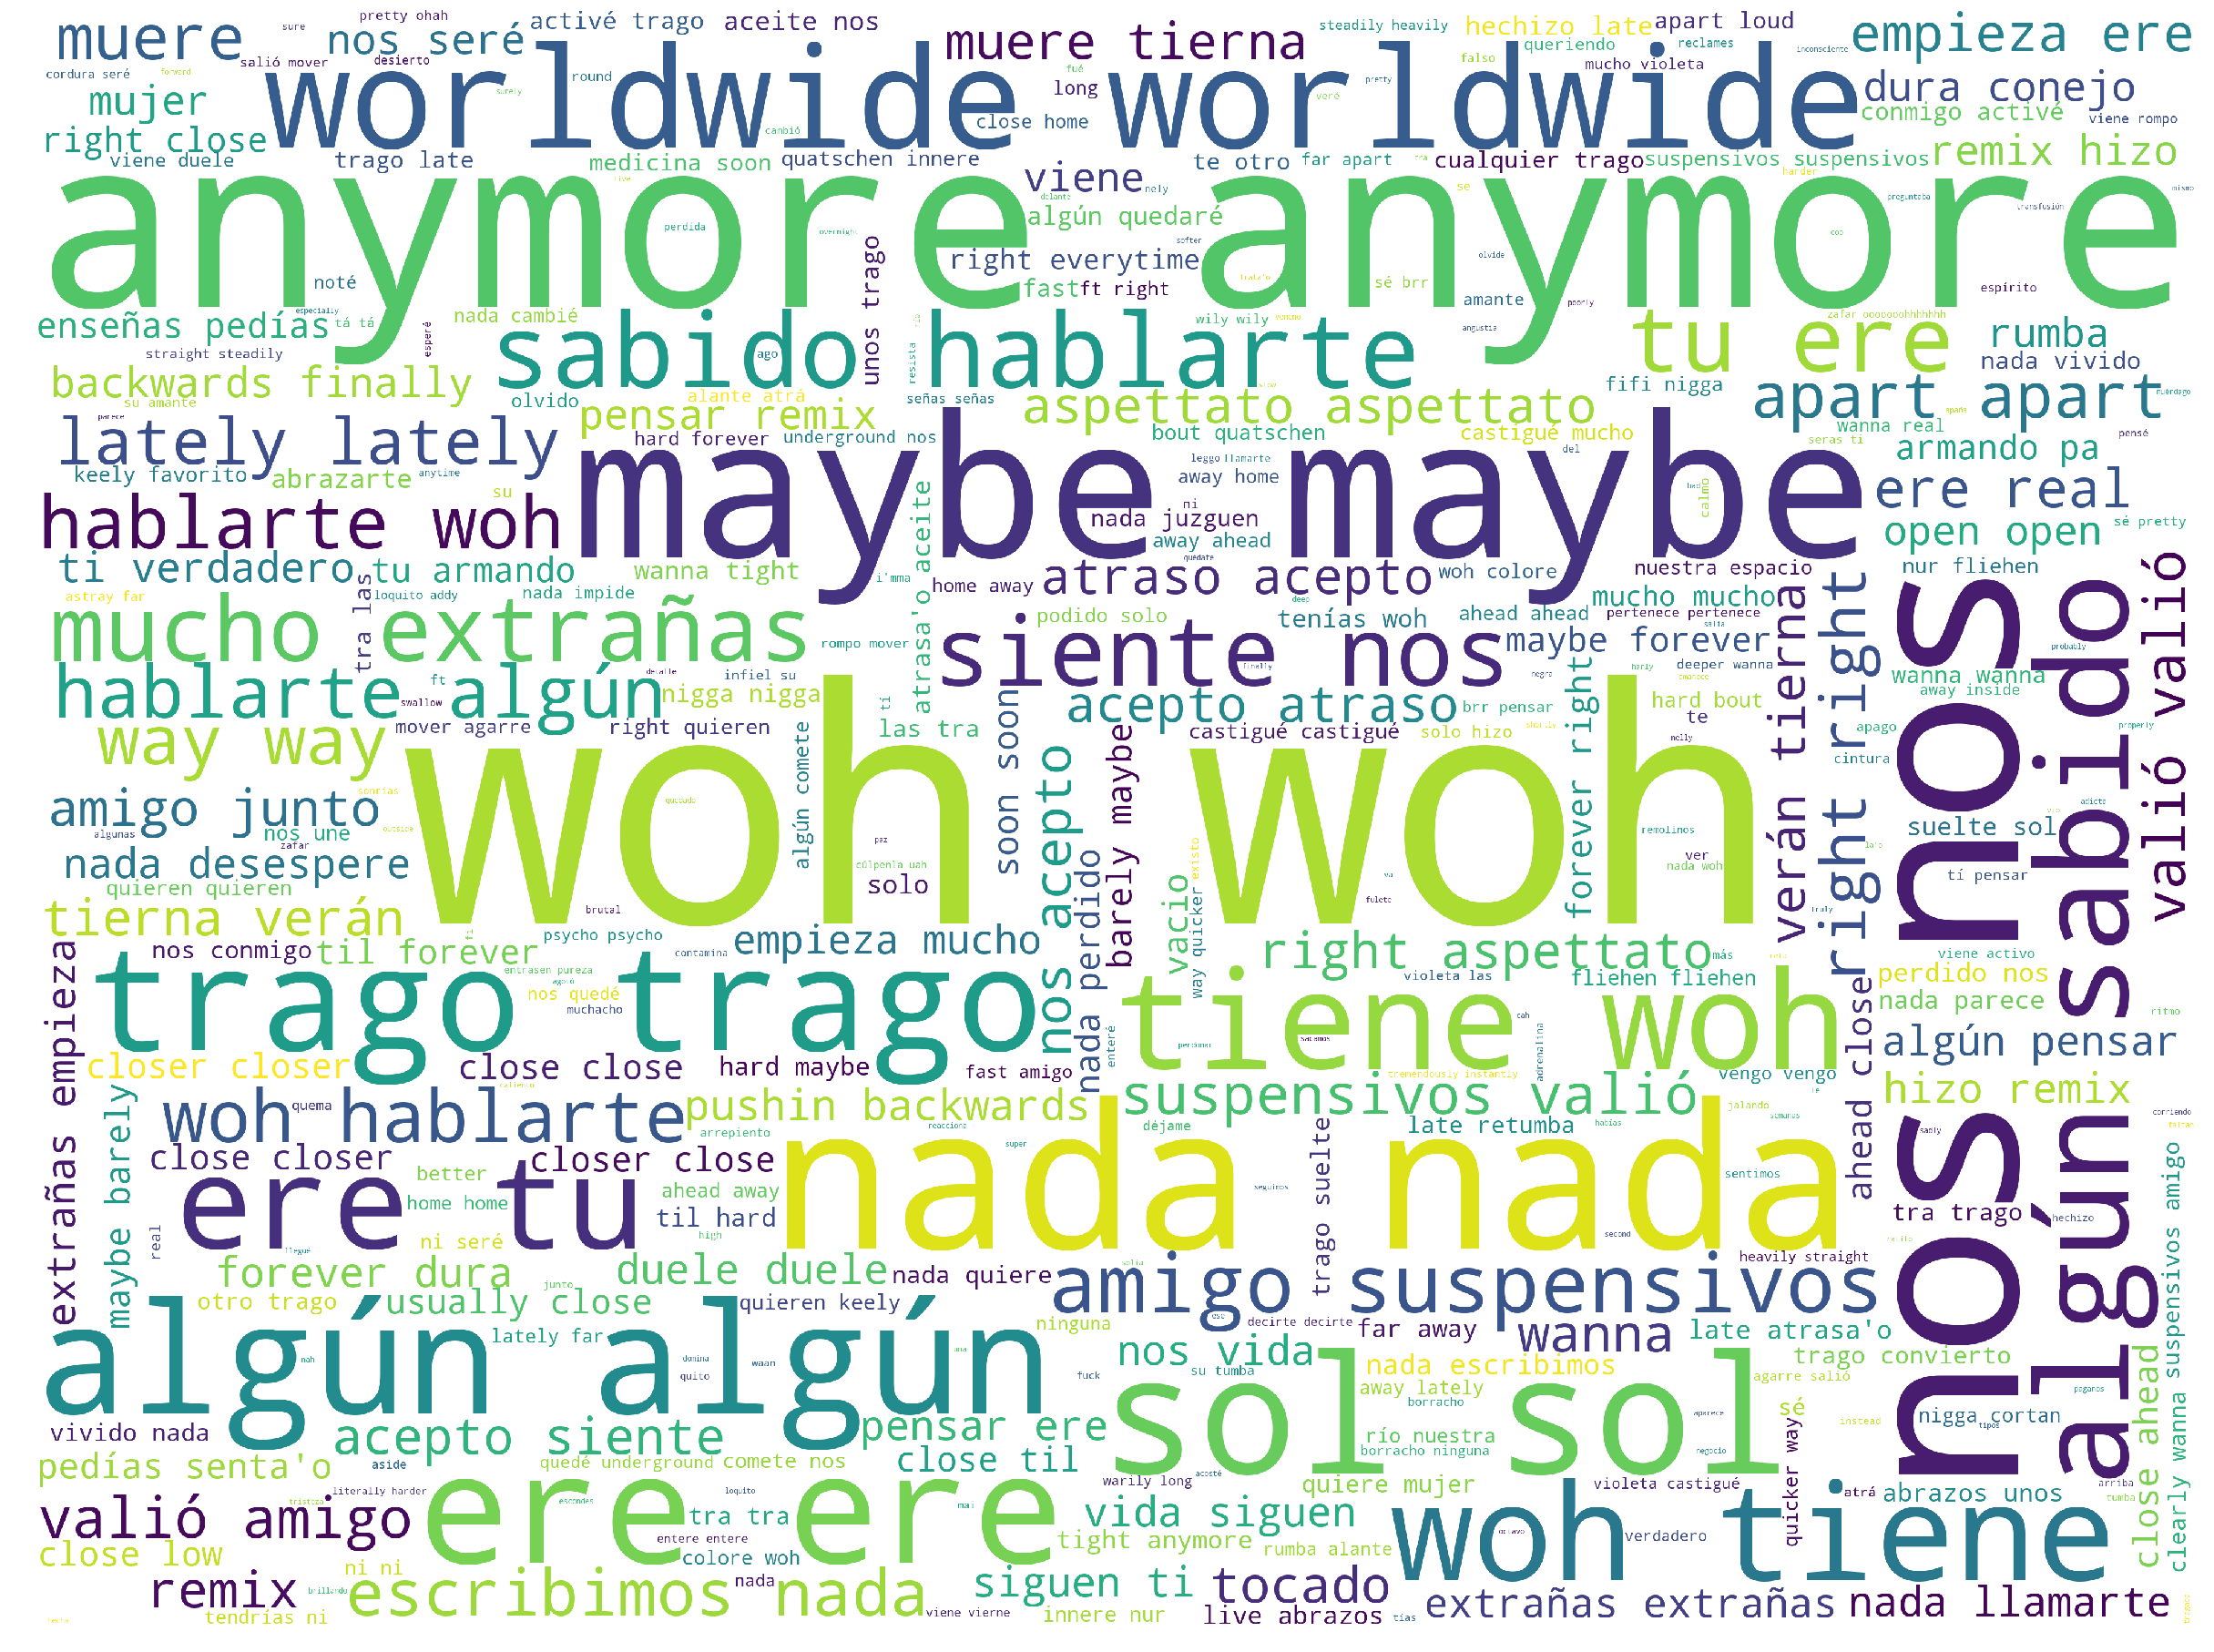

In [91]:
group_0_adverbs = [word for sublist in list(group_0_lyrics['adverbs']) for word in sublist]
group_0_adverbs = ' '.join(group_0_adverbs)
wordcloud(group_0_adverbs, 400)

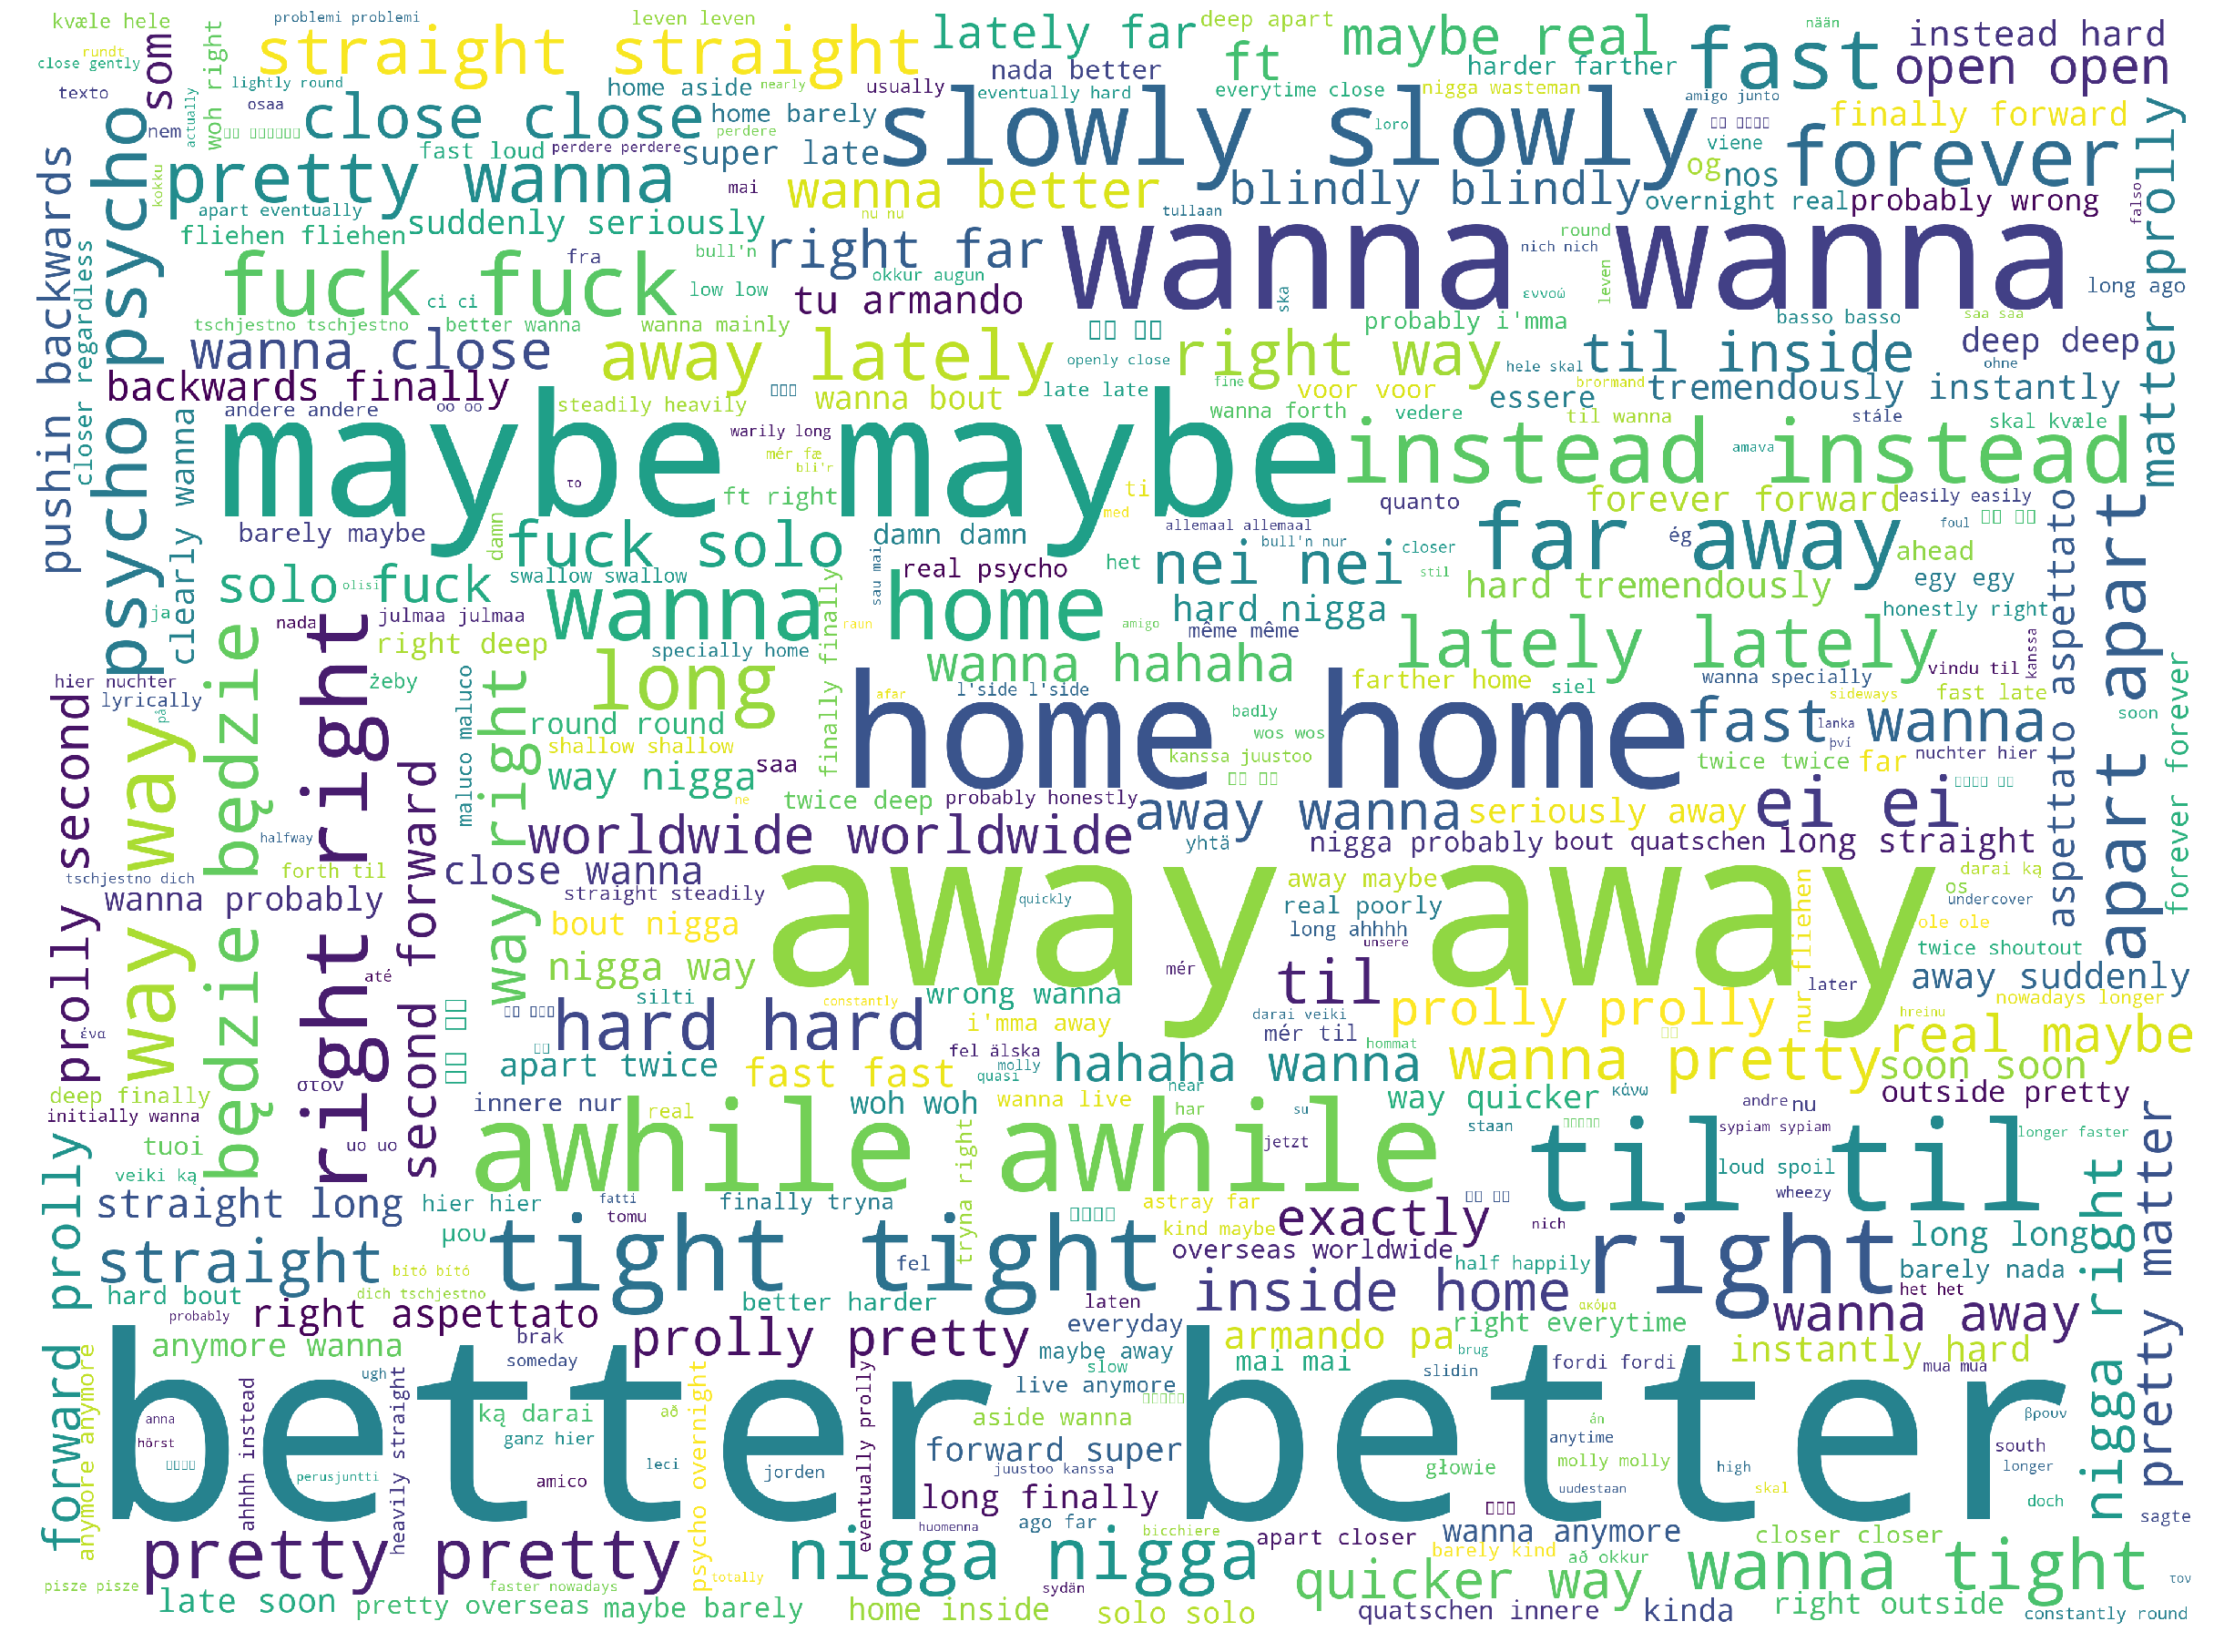

In [92]:
group_1_adverbs = [word for sublist in list(group_1_lyrics['adverbs']) for word in sublist]
group_1_adverbs = ' '.join(group_1_adverbs)
wordcloud(group_1_adverbs, 400)

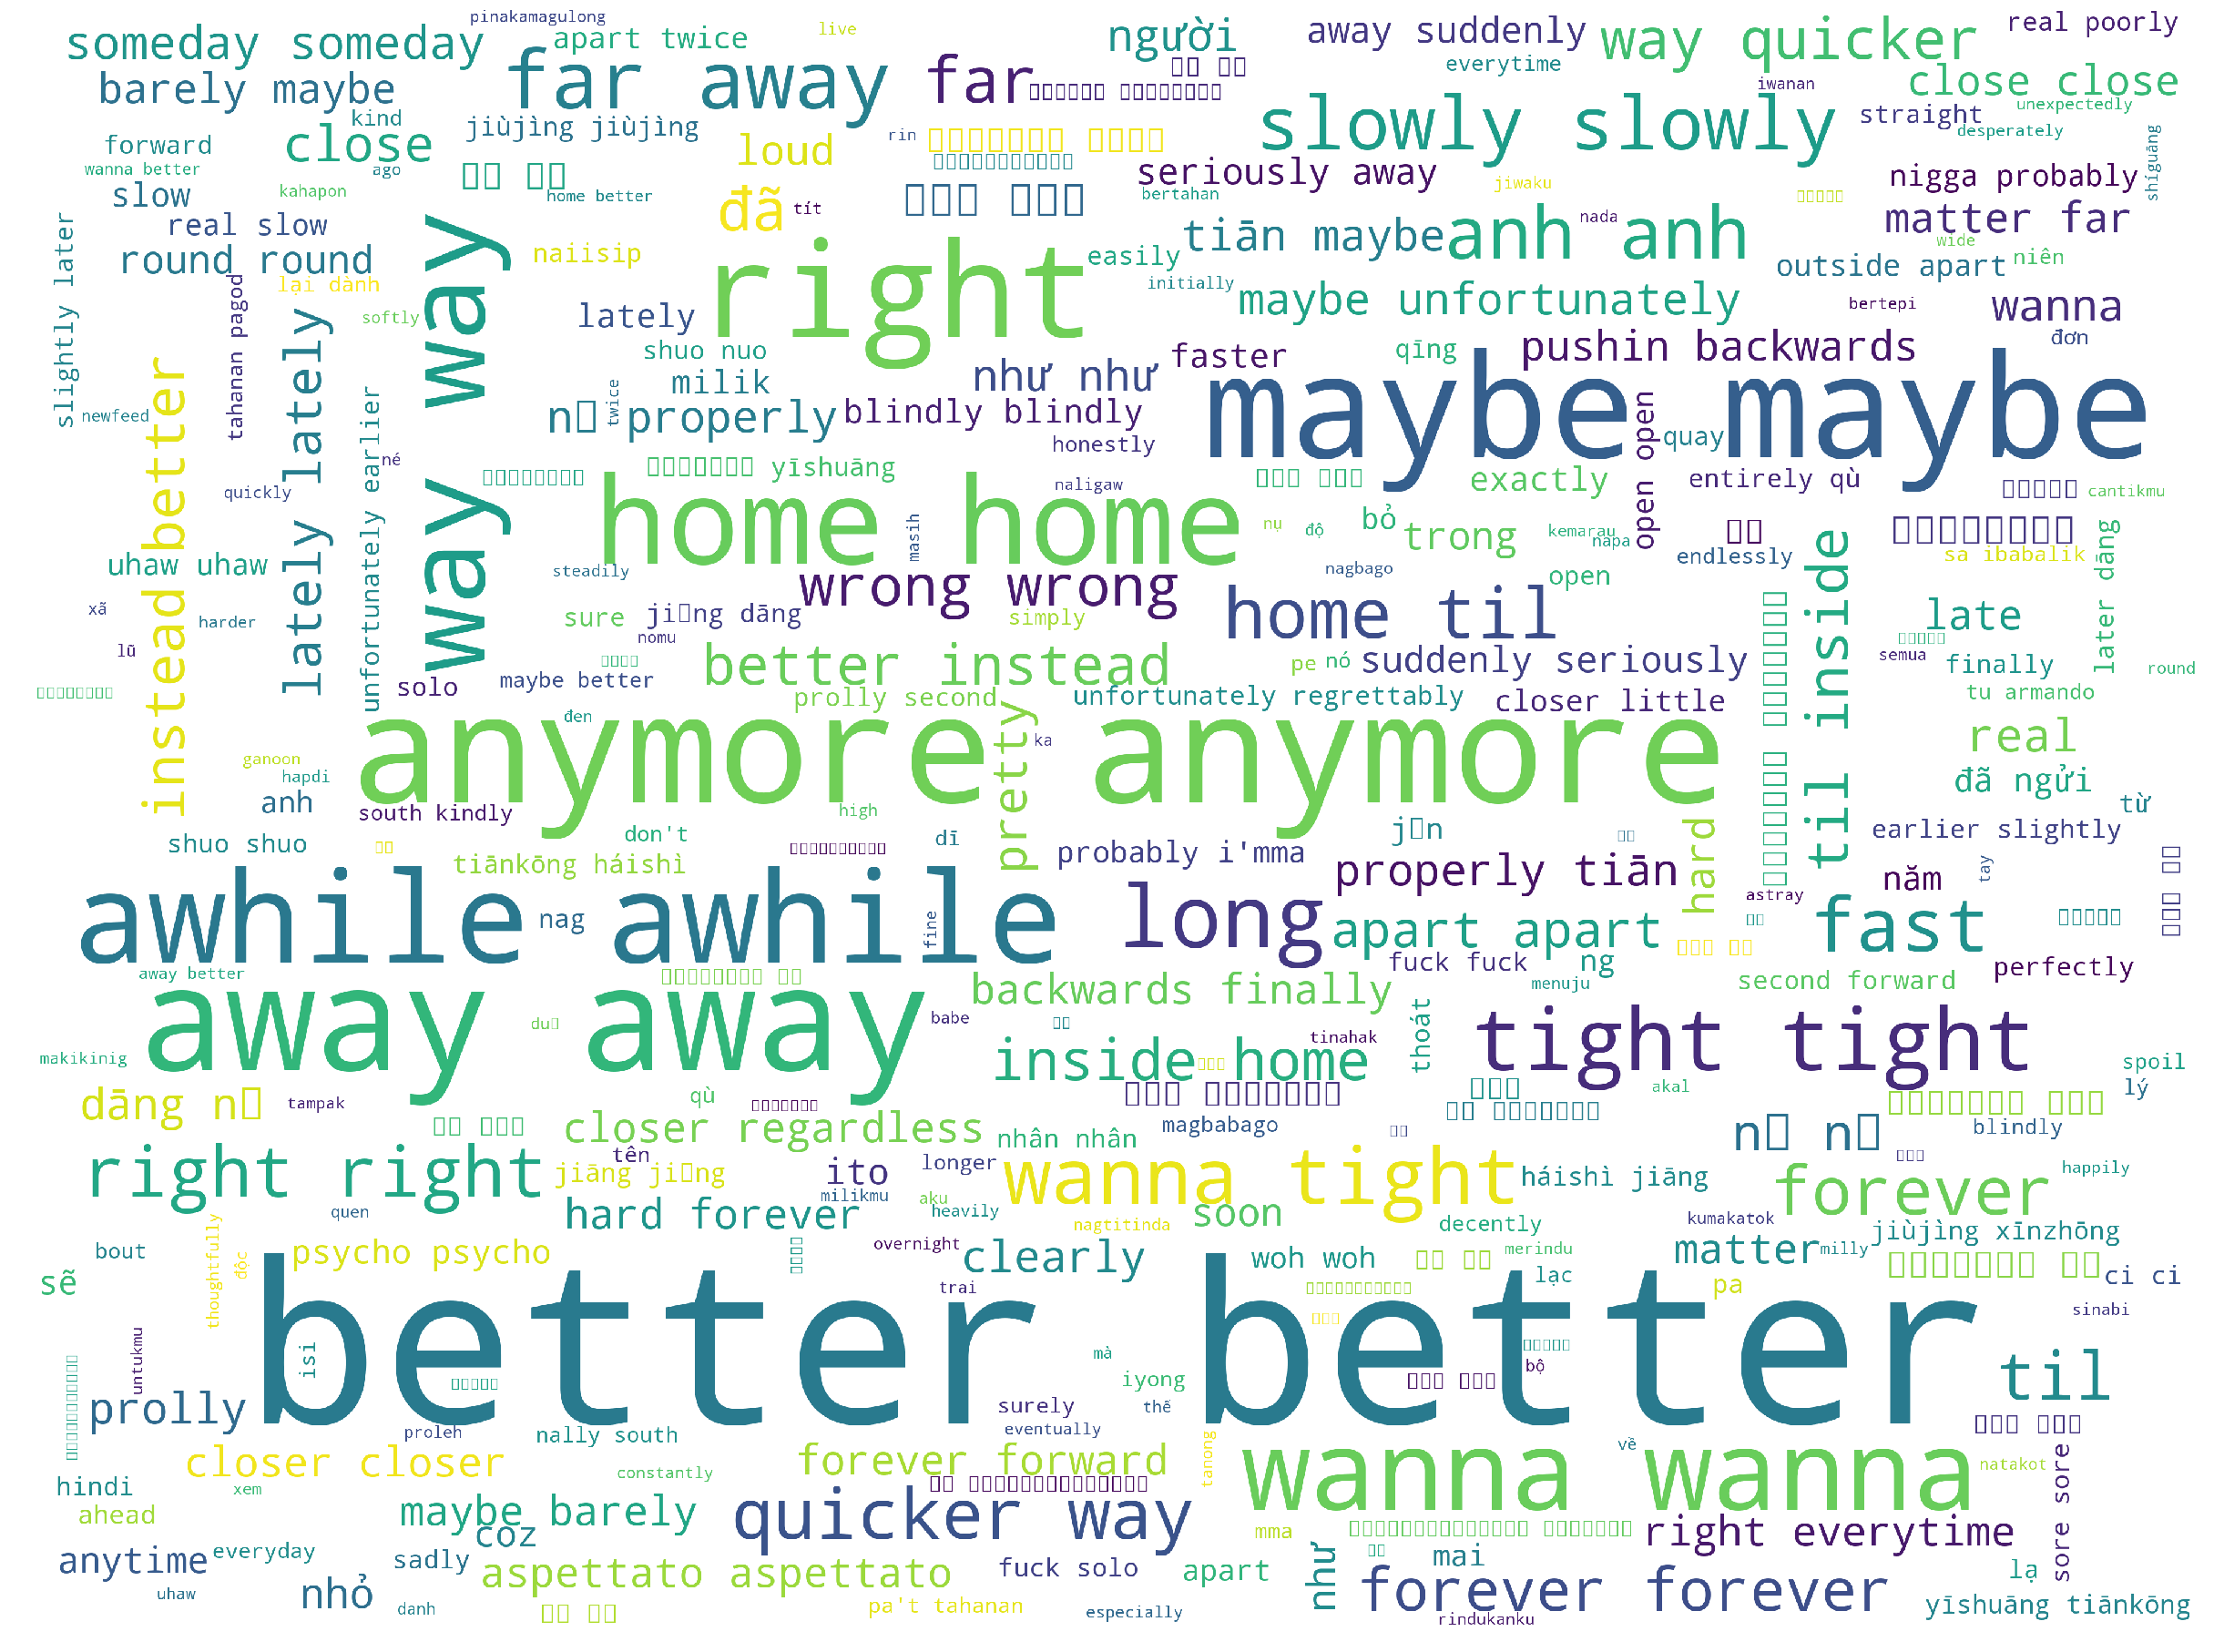

In [93]:
group_2_adverbs = [word for sublist in list(group_2_lyrics['adverbs']) for word in sublist]
group_2_adverbs = ' '.join(group_2_adverbs)
wordcloud(group_2_adverbs, 400)